In [1]:
from paths import heat_out_merra2
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin_control
from paths import heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax_control
from paths import trefhtmn_members
from paths import trefhtmx_members
from paths import merra2_download
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import xarray
import cartopy.crs as ccrs
from scipy.stats.stats import pearsonr

/tmp/ipykernel_73128/3869080014.py:12: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [1]:
from paths import merra2_download
from paths import trefhtmn_members
from paths import trefhtmx_members
import xarray

merra2_max = xarray.open_dataset(merra2_download())["T2MMAX"]
merra2_min = xarray.open_dataset(merra2_download())["T2MMIN"]
max_coeffs = merra2_max.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
min_coeffs = merra2_min.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
merra2_max_detrended = merra2_max - xarray.polyval(merra2_max.time, max_coeffs)
merra2_min_detrended = merra2_min - xarray.polyval(merra2_min.time, min_coeffs)
merra2_max_anomalies = merra2_max_detrended.groupby("time.dayofyear") - merra2_max_detrended.groupby("time.dayofyear").mean()
merra2_min_anomalies = merra2_min_detrended.groupby("time.dayofyear") - merra2_min_detrended.groupby("time.dayofyear").mean()

In [6]:
merra2_max

<xarray.DataArray 'T2MMAX' (time: 13149, lat: 361, lon: 576)>
[2734150464 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2015-12-31T12:00:00
Attributes:
    standard_name:   2-meter_air_temperature
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

In [3]:
all_min_avg = xarray.open_mfdataset([x for x in trefhtmn_members()[0] if ".nc" in x], concat_dim="member", combine="nested")["TREFHTMN"].mean(dim="member").sel(time=slice("1980-01-01", "2015-01-01"))

In [ ]:
trefhtmx_members()[0]

In [7]:
all_max_avg = xarray.open_mfdataset(trefhtmx_members()[0], concat_dim="member", combine="nested")["TREFHTMX"].mean(dim="member").sel(time=slice("1980-01-01", "2015-01-01"))
all_min_avg =xarray.open_mfdataset([x for x in trefhtmn_members()[0] if ".nc" in x], concat_dim="member", combine="nested")["TREFHTMN"].mean(dim="member").sel(time=slice("1980-01-01", "2015-01-01"))

max_coeffs = all_max_avg.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
min_coeffs = all_min_avg.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
all_max_detrended = all_max_avg - xarray.polyval(all_max_avg.time, max_coeffs)
all_min_detrended = all_min_avg - xarray.polyval(all_min_avg.time, min_coeffs)
all_max_anomalies = all_max_detrended.groupby("time.dayofyear") - all_max_detrended.groupby("time.dayofyear").mean()
all_min_anomalies = all_min_detrended.groupby("time.dayofyear") - all_min_detrended.groupby("time.dayofyear").mean()


/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 36 times more chunks
  return self.array[key]
/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 36 times more chunks
  return self.array[key]


In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 15), facecolor='w', subplot_kw=dict(projection=ccrs.PlateCarree()))
f.suptitle(f"MERRA2 vs ALL Variance Comparison", fontsize=26)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

cmap="seismic"
# vmax=1
# vmin=-1

merra2_max_avg.plot(ax=ax1, cmap=cmap, vmax=vmax, vmin=vmin)
ax1.set_title("MERRA2 Temp. Max. Variance 1980-2014")
ax1.coastlines()
merra2_min_avg.plot(ax=ax2, cmap=cmap, vmax=vmax, vmin=vmin)
ax2.set_title("MERRA2 Temp. Min. Variance 1980-2014")
ax2.coastlines()
all_max_avg.plot(ax=ax3, cmap=cmap, vmax=vmax, vmin=vmin)
ax3.set_title("ALL Temp. Max. Variance 1920-1930")
ax3.coastlines()
all_min_avg.plot(ax=ax4, cmap=cmap, vmax=vmax, vmin=vmin)
ax4.set_title("ALL Temp. Min. Variance 1920-1930")
ax4.coastlines()

f.tight_layout()
f.savefig("out.png")

In [56]:
def autocorrelation(o_data: xarray.DataArray) -> xarray.DataArray:
    """
    Calculates correlation between dataset and itself shifted by one time interval
    o_data -> Data array with dimensions latitude, longitude, and time
    """
    shifted_data = o_data.shift(time=1)

    o_data_vals = np.moveaxis(o_data.values, 0, -1)
    shifted_data_vals = np.moveaxis(shifted_data.values, 0, -1)
    correlation = np.zeros((o_data_vals.shape[0], o_data_vals.shape[1]))

    for i in range(0, o_data_vals.shape[0]):
        for j in range(0, o_data_vals.shape[1]):
            correlation[i][j] = pearsonr(np.nan_to_num(o_data_vals[i][j]), np.nan_to_num(shifted_data_vals[i][j]))[0]
    correlation_data = o_data.mean(dim="time").rename("Autocorrelation")
    correlation_data.values = correlation
    return correlation_data

variable = "HWF"
exp_num = "3136"

merra2_filtered_paths = [path for path in heat_out_merra2() if exp_num in path]
print("Calculating MERRA2 Max. autocorrelation")
merra2_max_avg = autocorrelation(xarray.open_mfdataset(merra2_filtered_paths[0], concat_dim="member", combine="nested")[f"{variable}_tx9pct"].dt.days.mean(dim="member"))
print("Calculating MERRA2 Min. autocorrelation")
merra2_min_avg = autocorrelation(xarray.open_mfdataset(merra2_filtered_paths[1], concat_dim="member", combine="nested")[f"{variable}_tn9pct"].dt.days.mean(dim="member"))

all_max_filtered_paths = [path for path in trefhtmx_members()[0] if exp_num in path]
all_min_filtered_paths = [path for path in trefhtmn_members()[0] if exp_num in path]
print("Calculating ALL Max. autocorrelation")
all_max_avg = autocorrelation(xarray.open_mfdataset(all_max_filtered_paths, concat_dim="member", combine="nested")[f"{variable}_tx90"].dt.days.mean(dim="member").sel(time=slice(1920, 1930)))
print("Calculating ALL Min. autocorrelation")
all_min_avg =autocorrelation(xarray.open_mfdataset(all_min_filtered_paths, concat_dim="member", combine="nested")[f"{variable}_tn90"].dt.days.mean(dim="member").sel(time=slice(1920, 1930)))

Calculating MERRA2 Max. autocorrelation


/projects/dgs/rh5_local/anaconda/climate/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating MERRA2 Min. autocorrelation


/projects/dgs/rh5_local/anaconda/climate/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating ALL Max. autocorrelation


/projects/dgs/rh5_local/anaconda/climate/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating ALL Min. autocorrelation


/projects/dgs/rh5_local/anaconda/climate/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


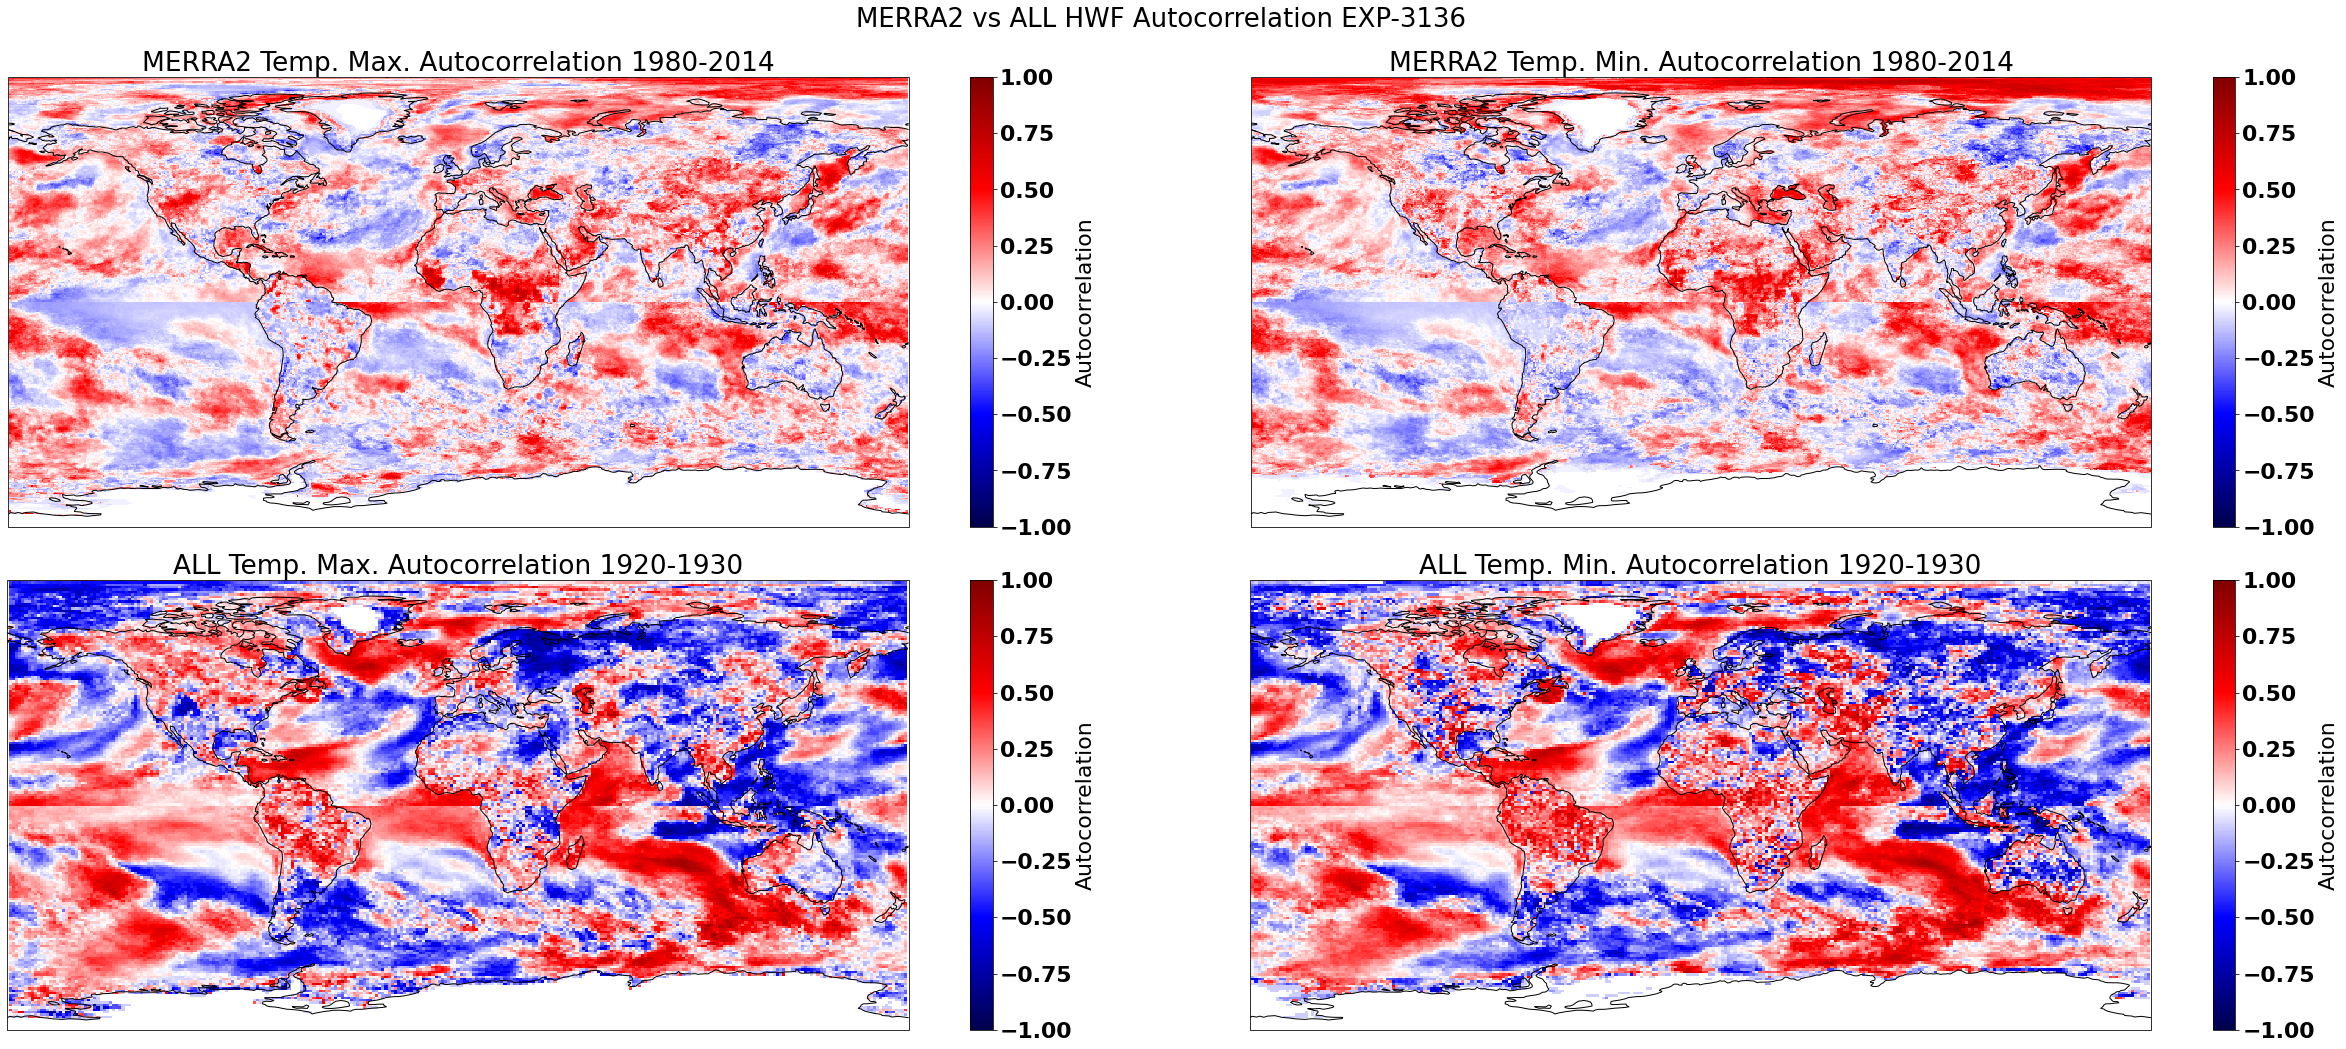

In [5]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 15), facecolor='w', subplot_kw=dict(projection=ccrs.PlateCarree()))
f.suptitle(f"MERRA2 vs ALL {variable} Autocorrelation EXP-{exp_num}", fontsize=26)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

cmap="seismic"
vmax=1
vmin=-1

merra2_max_avg.plot(ax=ax1, cmap=cmap, vmax=vmax, vmin=vmin)
ax1.set_title("MERRA2 Temp. Max. Autocorrelation 1980-2014")
ax1.coastlines()
merra2_min_avg.plot(ax=ax2, cmap=cmap, vmax=vmax, vmin=vmin)
ax2.set_title("MERRA2 Temp. Min. Autocorrelation 1980-2014")
ax2.coastlines()
all_max_avg.plot(ax=ax3, cmap=cmap, vmax=vmax, vmin=vmin)
ax3.set_title("ALL Temp. Max. Autocorrelation 1920-1930")
ax3.coastlines()
all_min_avg.plot(ax=ax4, cmap=cmap, vmax=vmax, vmin=vmin)
ax4.set_title("ALL Temp. Min. Autocorrelation 1920-1930")
ax4.coastlines()

f.tight_layout()
f.savefig("out.png")

In [17]:
import warnings
all_max_em_avg = xarray.open_mfdataset(all_max_filtered_paths, concat_dim="member", combine="nested")[f"{variable}_tx90"].dt.days.mean(dim="member")
plotted_data = np.zeros(all_max_em_avg.time.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, year in enumerate(all_max_em_avg.time[1::].values):
        print(year, end=" ")
        plotted_data[i] = autocorrelation(all_max_em_avg.sel(time=slice(year-1, year))).mean(dim="lat").mean(dim="lon").values

1921.0 1922.0 1923.0 1924.0 1925.0 1926.0 1927.0 1928.0 1929.0 1930.0 1931.0 1932.0 1933.0 1934.0 1935.0 1936.0 1937.0 1938.0 1939.0 1940.0 1941.0 1942.0 1943.0 1944.0 1945.0 1946.0 1947.0 1948.0 1949.0 1950.0 1951.0 1952.0 1953.0 1954.0 1955.0 1956.0 1957.0 1958.0 1959.0 1960.0 1961.0 1962.0 1963.0 1964.0 1965.0 1966.0 1967.0 1968.0 1969.0 1970.0 1971.0 1972.0 1973.0 1974.0 1975.0 1976.0 1977.0 1978.0 1979.0 1980.0 1981.0 1982.0 1983.0 1984.0 1985.0 1986.0 1987.0 1988.0 1989.0 1990.0 1991.0 1992.0 1993.0 1994.0 1995.0 1996.0 1997.0 1998.0 1999.0 2000.0 2001.0 2002.0 2003.0 2004.0 2005.0 2006.0 2007.0 2008.0 2009.0 2010.0 2011.0 2012.0 2013.0 2014.0 2015.0 2016.0 2017.0 2018.0 2019.0 2020.0 2021.0 2022.0 2023.0 2024.0 2025.0 2026.0 2027.0 2028.0 2029.0 2030.0 2031.0 2032.0 2033.0 2034.0 2035.0 2036.0 2037.0 2038.0 2039.0 2040.0 2041.0 2042.0 2043.0 2044.0 2045.0 2046.0 2047.0 2048.0 2049.0 2050.0 2051.0 2052.0 2053.0 2054.0 2055.0 2056.0 2057.0 2058.0 2059.0 2060.0 2061.0 2062.0 2063.0

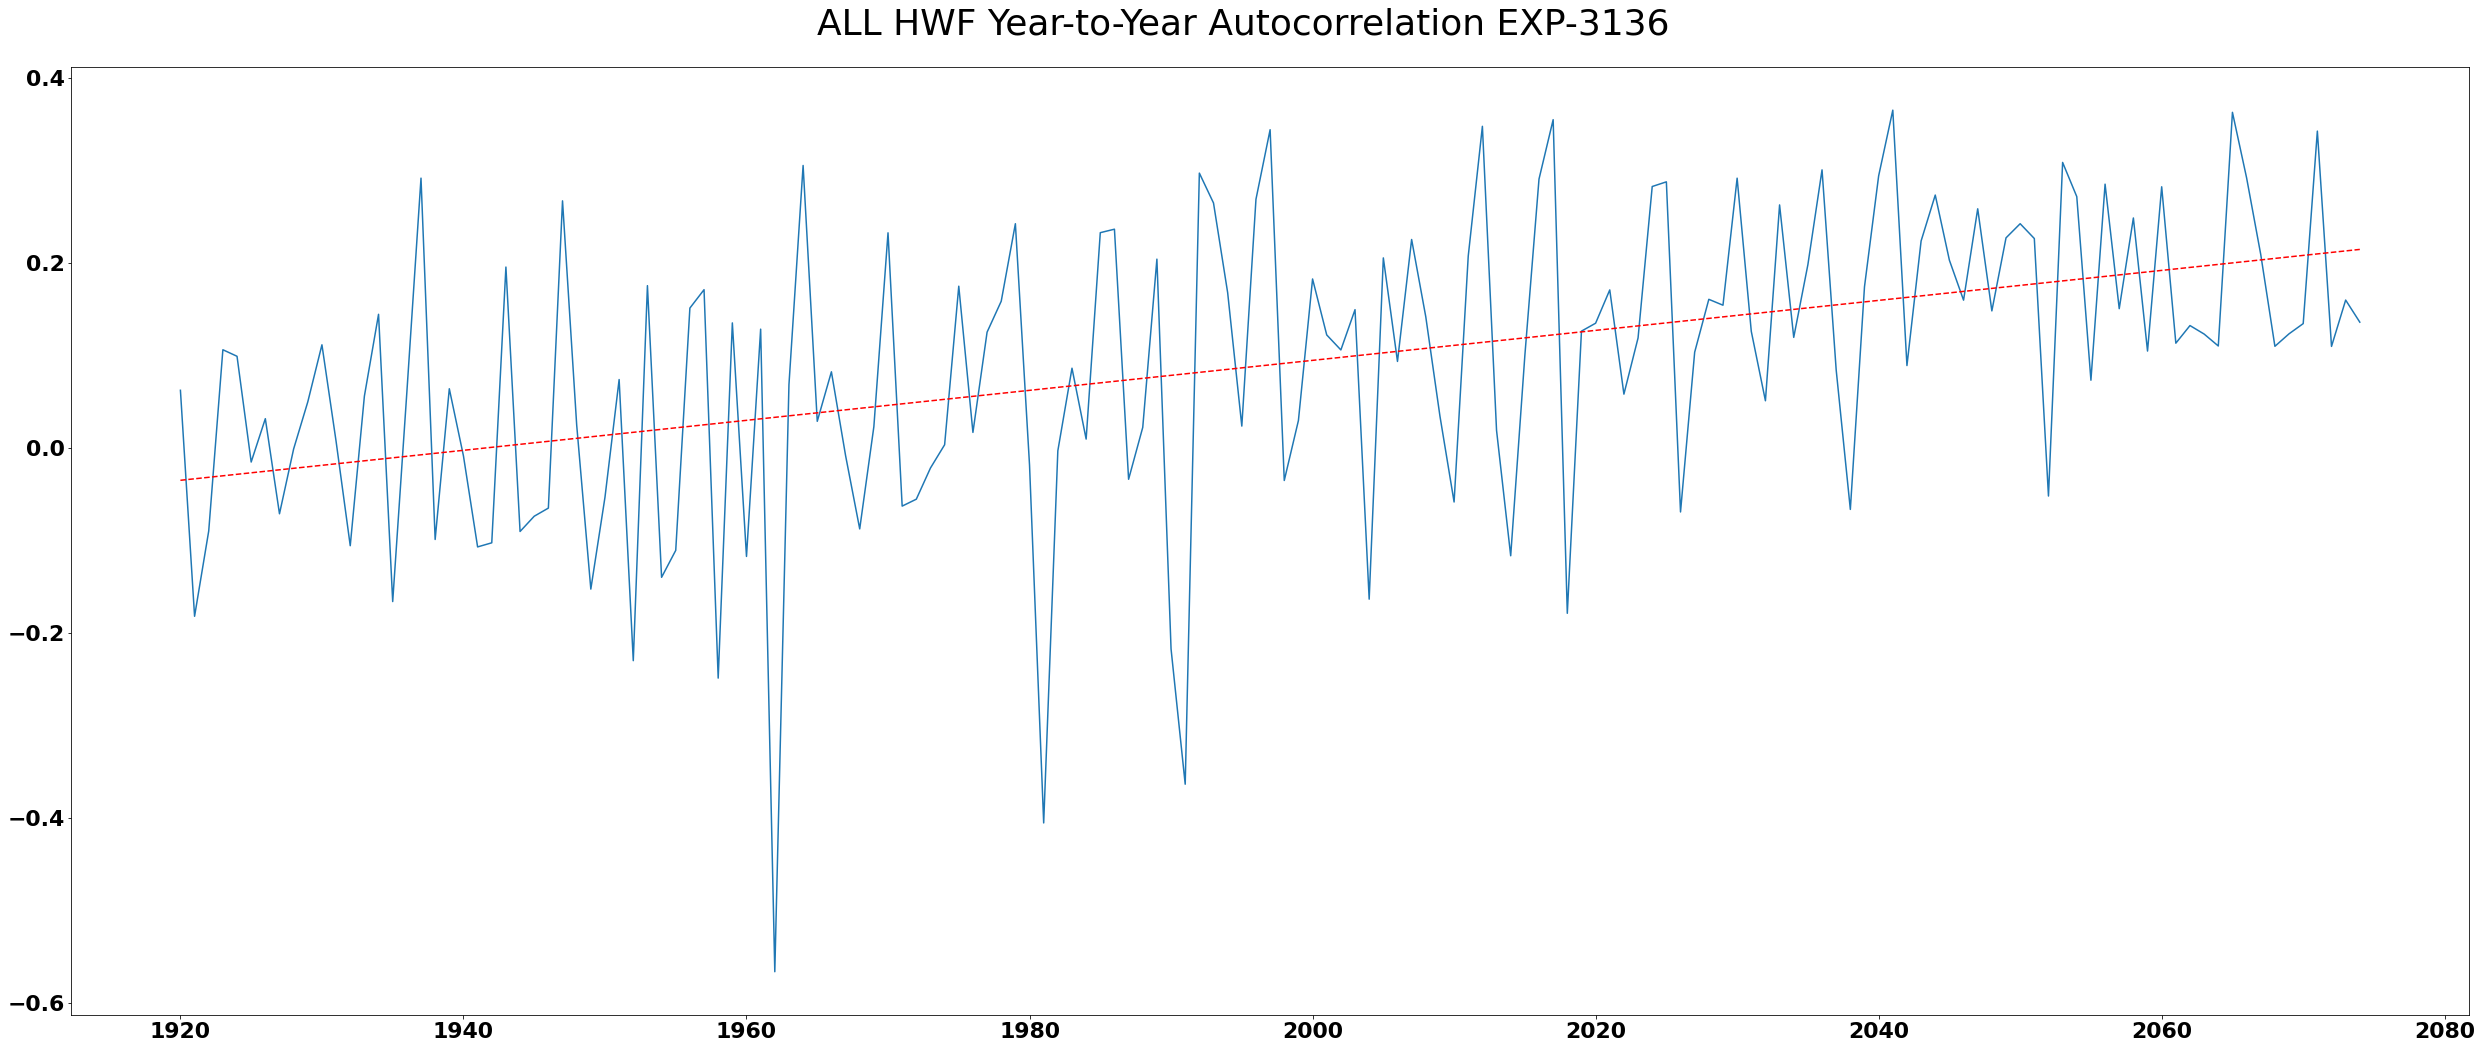

In [29]:
f, ax = plt.subplots(1, 1, figsize=(35, 15), facecolor='w')
f.suptitle(f"ALL {variable} Year-to-Year Autocorrelation EXP-{exp_num}", fontsize=36)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

x = all_max_em_avg.time.values[0:155]
y = plotted_data[0:155]
ax.plot(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--")

f.tight_layout()
f.savefig("all_year_to_year_autocorrelation.png")

In [30]:
import warnings
all_max_em_avg = xarray.open_mfdataset(all_max_filtered_paths, concat_dim="member", combine="nested")[f"{variable}_tx90"].dt.days.mean(dim="member")
plotted_data_2 = np.zeros(all_max_em_avg.time.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, year in enumerate(all_max_em_avg.time[5::].values):
        print(year, end=" ")
        plotted_data[i] = autocorrelation(all_max_em_avg.sel(time=slice(year-5, year))).mean(dim="lat").mean(dim="lon").values

1925.0 1926.0 1927.0 1928.0 1929.0 1930.0 1931.0 1932.0 1933.0 1934.0 1935.0 1936.0 1937.0 1938.0 1939.0 1940.0 1941.0 1942.0 1943.0 1944.0 1945.0 1946.0 1947.0 1948.0 1949.0 1950.0 1951.0 1952.0 1953.0 1954.0 1955.0 1956.0 1957.0 1958.0 1959.0 1960.0 1961.0 1962.0 1963.0 1964.0 1965.0 1966.0 1967.0 1968.0 1969.0 1970.0 1971.0 1972.0 1973.0 1974.0 1975.0 1976.0 1977.0 1978.0 1979.0 1980.0 1981.0 1982.0 1983.0 1984.0 1985.0 1986.0 1987.0 1988.0 1989.0 1990.0 1991.0 1992.0 1993.0 1994.0 1995.0 1996.0 1997.0 1998.0 1999.0 2000.0 2001.0 2002.0 2003.0 2004.0 2005.0 2006.0 2007.0 2008.0 2009.0 2010.0 2011.0 2012.0 2013.0 2014.0 2015.0 2016.0 2017.0 2018.0 2019.0 2020.0 2021.0 2022.0 2023.0 2024.0 2025.0 2026.0 2027.0 2028.0 2029.0 2030.0 2031.0 2032.0 2033.0 2034.0 2035.0 2036.0 2037.0 2038.0 2039.0 2040.0 2041.0 2042.0 2043.0 2044.0 2045.0 2046.0 2047.0 2048.0 2049.0 2050.0 2051.0 2052.0 2053.0 2054.0 2055.0 2056.0 2057.0 2058.0 2059.0 2060.0 2061.0 2062.0 2063.0 2064.0 2065.0 2066.0 2067.0

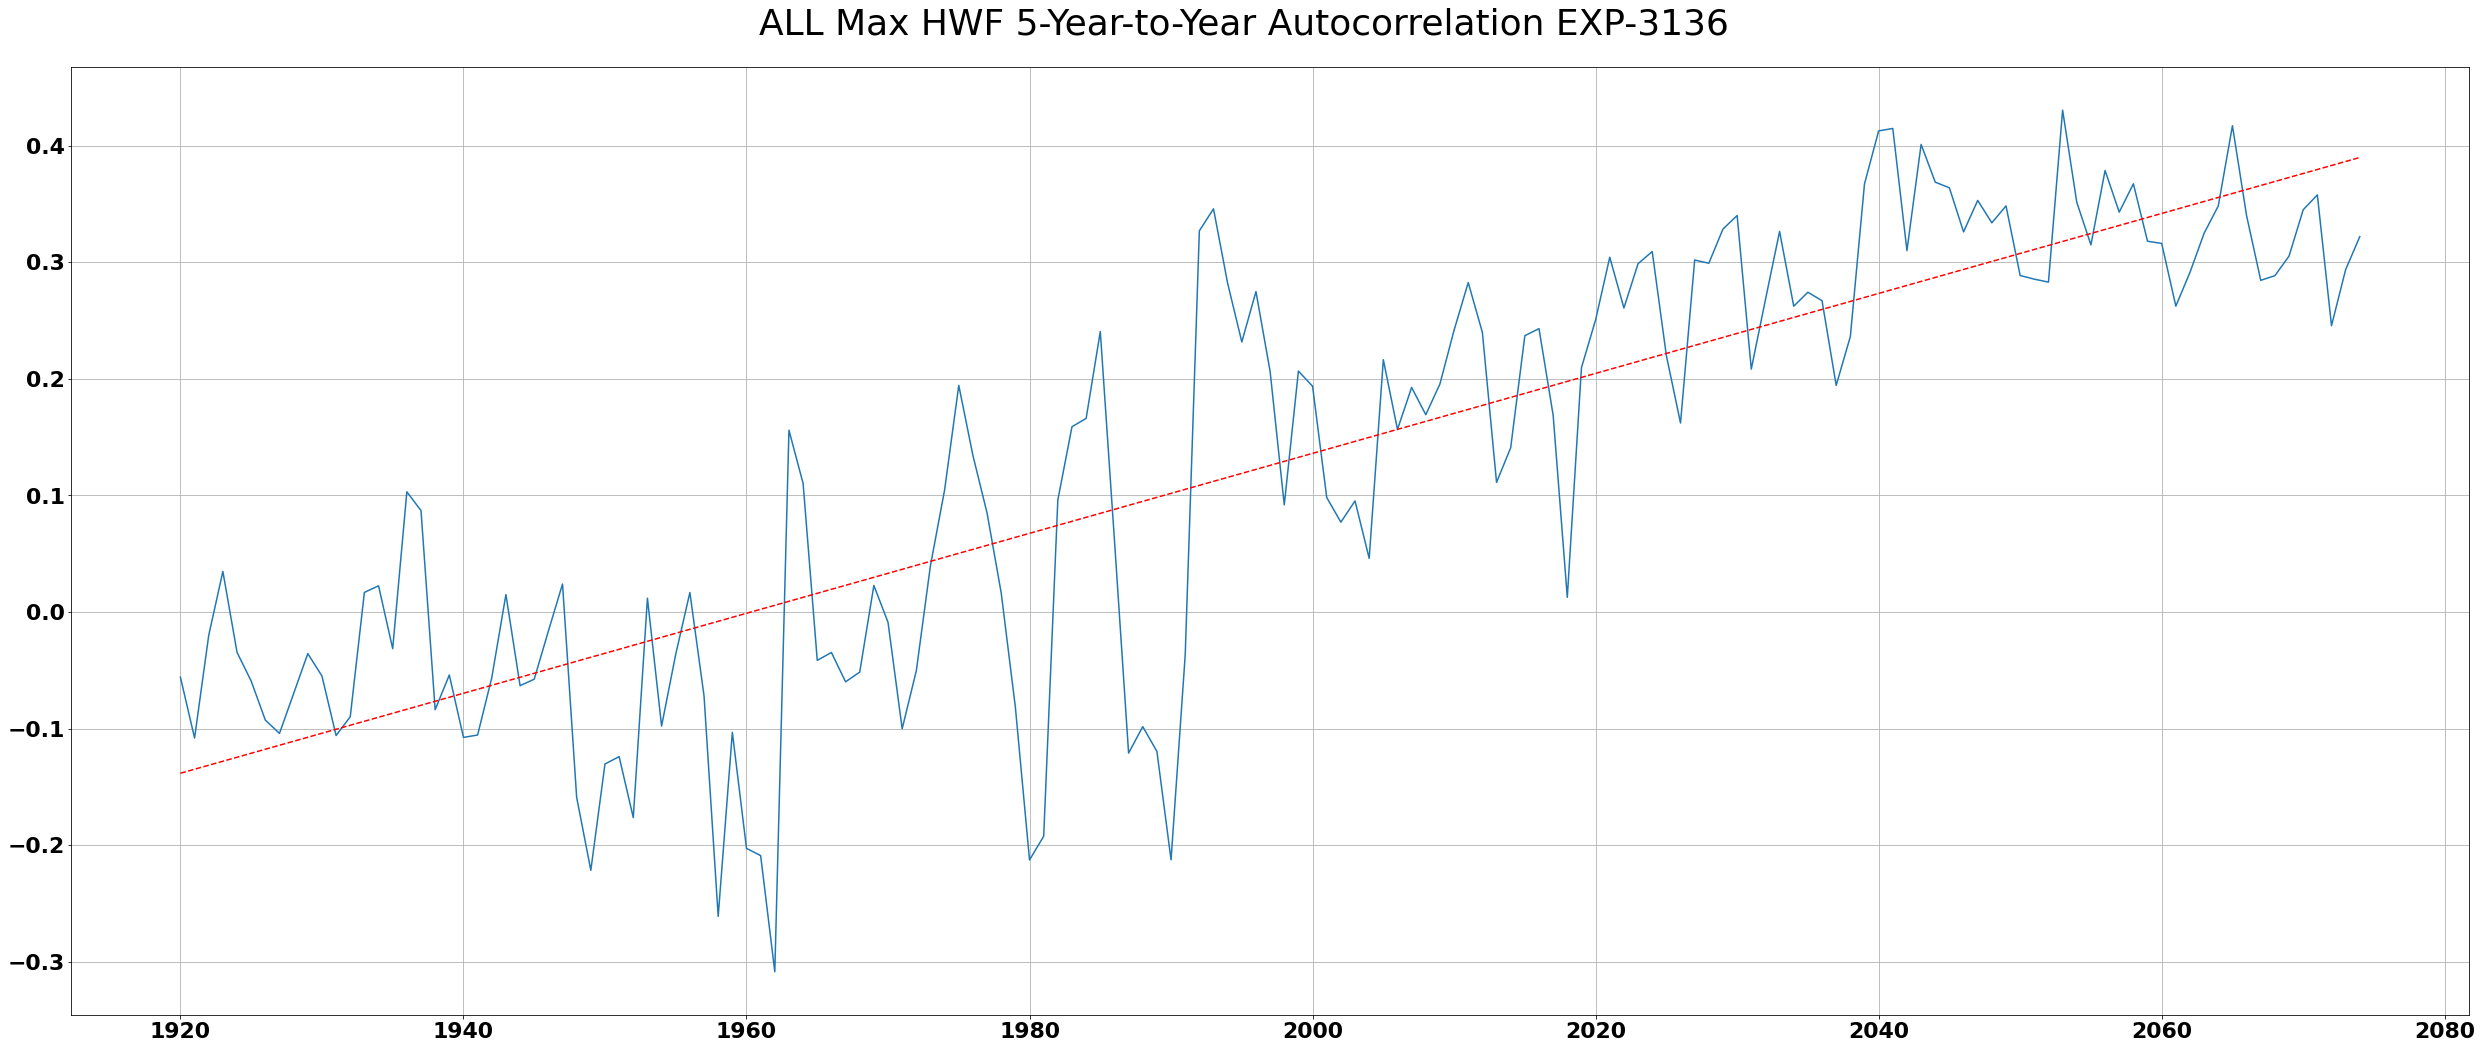

In [38]:
f, ax = plt.subplots(1, 1, figsize=(35, 15), facecolor='w')
f.suptitle(f"ALL Max {variable} 5-Year-to-Year Autocorrelation EXP-{exp_num}", fontsize=36)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

x = all_max_em_avg.time.values[0:155]
y = plotted_data[0:155]
ax.plot(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--")

f.tight_layout()
plt.grid()
f.savefig("all_year_to_5_year_autocorrelation.png")

In [ ]:
plot_data_3 = autocorrelation(all_max_em_avg.sel(time=slice(1980, 1985)))

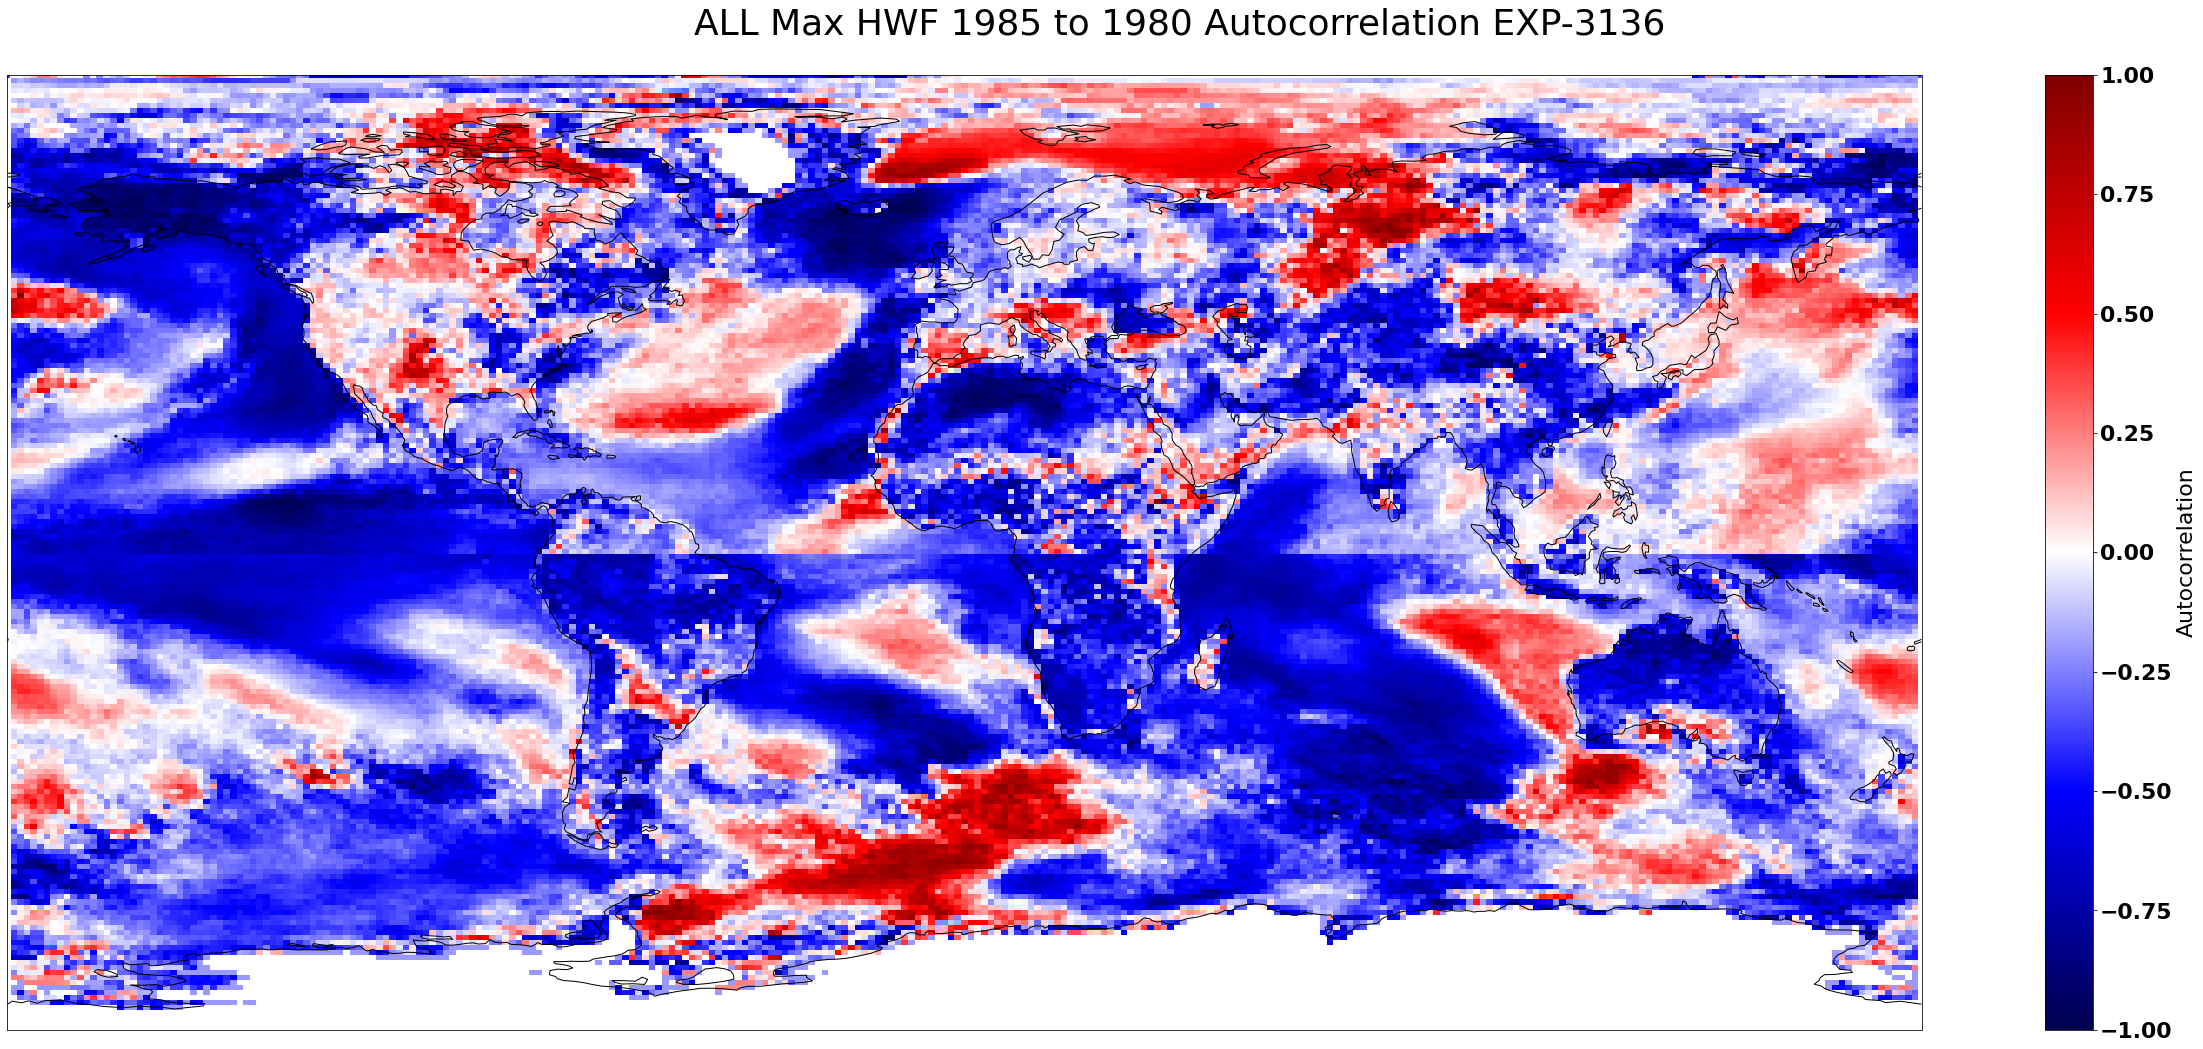

In [48]:
f, ax = plt.subplots(1, 1, figsize=(35, 15), facecolor='w', subplot_kw=dict(projection=ccrs.PlateCarree()))
f.suptitle(f"ALL Max {variable} 1985 to 1980 Autocorrelation EXP-{exp_num}", fontsize=36)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

plot_data_3.plot(ax = ax, cmap="seismic", vmax=1, vmin=-1)
ax.coastlines()

f.tight_layout()
f.savefig("all_max_1985_1980_autocorrelation.png")

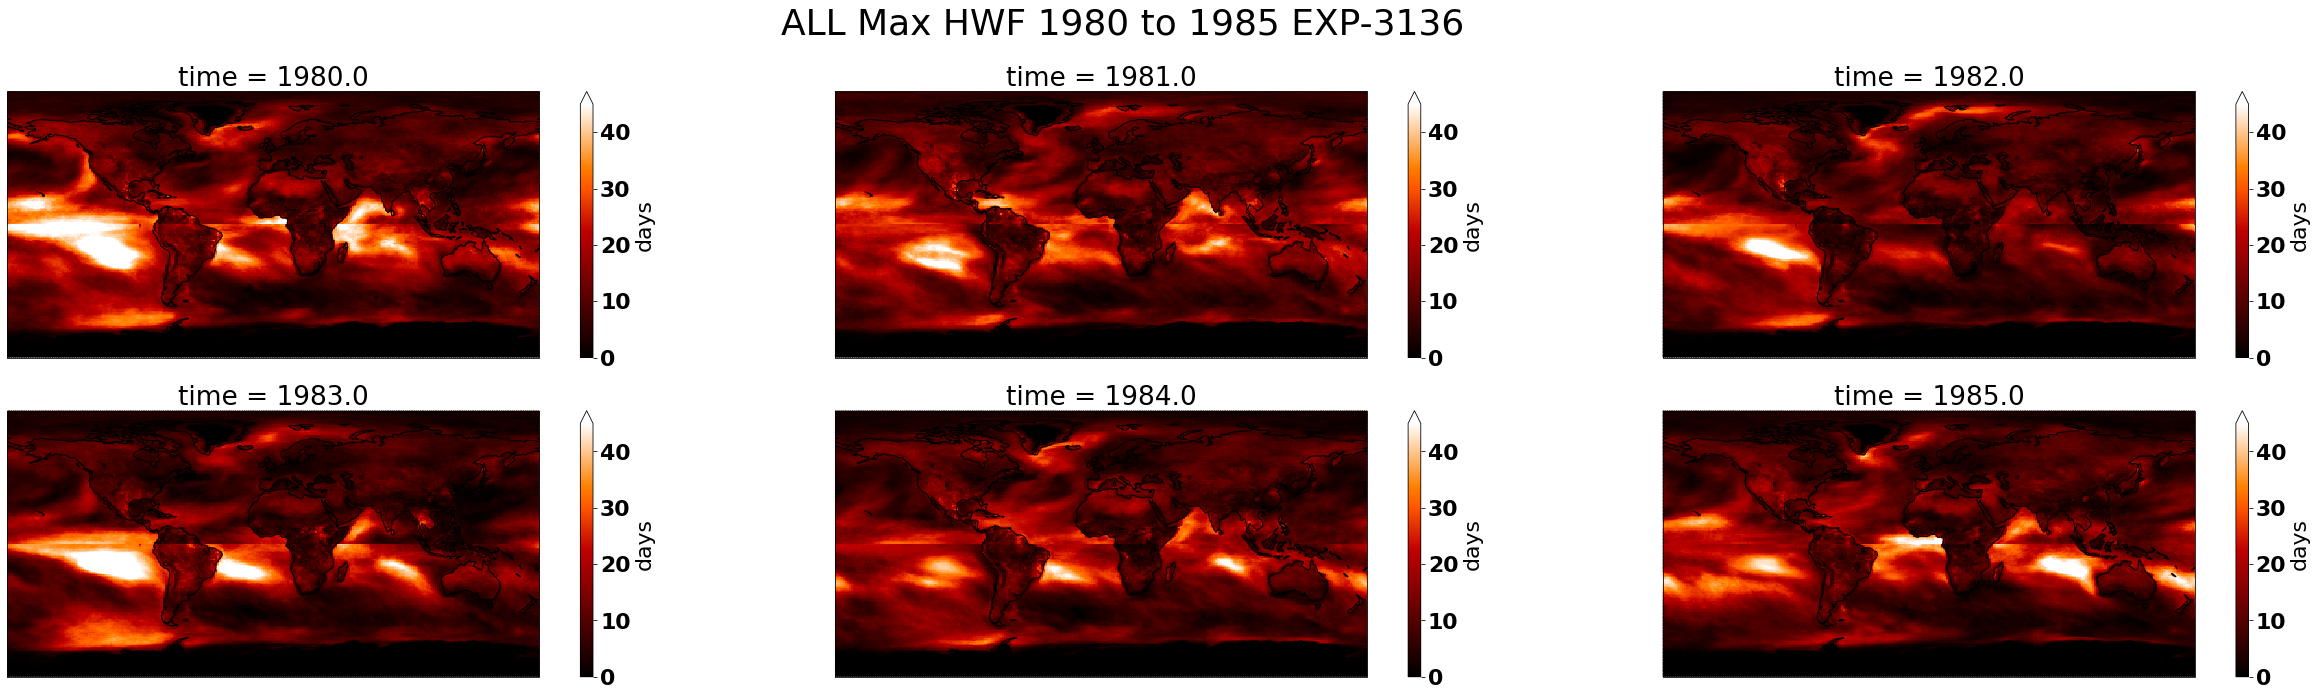

In [54]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(35, 10), facecolor='w', subplot_kw=dict(projection=ccrs.PlateCarree()))
f.suptitle(f"ALL Max {variable} 1980 to 1985 EXP-{exp_num}", fontsize=36)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

cmap="gist_heat"

all_max_em_avg.sel(time=1980).plot(ax=ax1, cmap=cmap, vmax=45)
ax1.coastlines()
all_max_em_avg.sel(time=1981).plot(ax=ax2, cmap=cmap, vmax=45)
ax2.coastlines()
all_max_em_avg.sel(time=1982).plot(ax=ax3, cmap=cmap, vmax=45)
ax3.coastlines()
all_max_em_avg.sel(time=1983).plot(ax=ax4, cmap=cmap, vmax=45)
ax4.coastlines()
all_max_em_avg.sel(time=1984).plot(ax=ax5, cmap=cmap, vmax=45)
ax5.coastlines()
all_max_em_avg.sel(time=1985).plot(ax=ax6, cmap=cmap, vmax=45)
ax6.coastlines()

f.tight_layout()
f.savefig("all_1985_1980_max.png")

In [60]:
xarray.open_dataset(merra2_download())["T2MMAX"]

<xarray.DataArray 'T2MMAX' (time: 13149, lat: 361, lon: 576)>
[2734150464 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2015-12-31T12:00:00
Attributes:
    standard_name:   2-meter_air_temperature
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0

In [1]:
from paths import merra2_download
import xarray
import numpy as np
from scipy.stats import pearsonr

def autocorrelation(o_data: xarray.DataArray) -> xarray.DataArray:
    """
    Calculates correlation between dataset and itself shifted by one time interval
    o_data -> Data array with dimensions latitude, longitude, and time
    """
    shifted_data = o_data.shift(time=1)

    o_data_vals = np.moveaxis(o_data.values, 0, -1)
    shifted_data_vals = np.moveaxis(shifted_data.values, 0, -1)
    correlation = np.zeros((o_data_vals.shape[0], o_data_vals.shape[1]))

    for i in range(0, o_data_vals.shape[0]):
        for j in range(0, o_data_vals.shape[1]):
            correlation[i][j] = pearsonr(np.nan_to_num(o_data_vals[i][j]), np.nan_to_num(shifted_data_vals[i][j]))[0]
    correlation_data = o_data.mean(dim="time").rename("Autocorrelation")
    correlation_data.values = correlation
    return correlation_data

# merra2_max = xarray.open_dataset(merra2_download())["T2MMAX"]
merra2_min = xarray.open_dataset(merra2_download())["T2MMIN"].load()
# max_coeffs = merra2_max.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
min_coeffs = merra2_min.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
# merra2_max_detrended = merra2_max - xarray.polyval(merra2_max.time, max_coeffs)
merra2_min_detrended = merra2_min - xarray.polyval(merra2_min.time, min_coeffs)
# merra2_max_anomalies = merra2_max_detrended.groupby("time.dayofyear") - merra2_max_detrended.groupby("time.dayofyear").mean()
merra2_min_anomalies = merra2_min_detrended.groupby("time.dayofyear") - merra2_min_detrended.groupby("time.dayofyear").mean()

# merra2_max_auto_anomalies = autocorrelation(merra2_max_anomalies)
merra2_min_auto_anomalies = autocorrelation(merra2_min_anomalies)

merra2_min_auto_anomalies.to_netcdf("../data/autocorrelation/auto_merra_min.nc")
# merra2_max_auto_anomalies.to_netcdf("auto_max_all.nc")

In [14]:
paths[5:10]

['/projects/dgs/persad_research/heat_research/data/TREFHTMN/ALL/concatenated/trefhtmin_all_11.nc',
 '/projects/dgs/persad_research/heat_research/data/TREFHTMN/ALL/concatenated/trefhtmin_all_10.nc',
 '/projects/dgs/persad_research/heat_research/data/TREFHTMN/ALL/concatenated/trefhtmin_all_8.nc',
 '/projects/dgs/persad_research/heat_research/data/TREFHTMN/ALL/concatenated/trefhtmin_all_12.nc',
 '/projects/dgs/persad_research/heat_research/data/TREFHTMN/ALL/concatenated/trefhtmin_all_13.nc']

In [5]:
[f"./tmp/{name}" for name in listdir("./tmp/")]

['./tmp/t7.nc',
 './tmp/t15.nc',
 './tmp/t14.nc',
 './tmp/t6.nc',
 './tmp/t4.nc',
 './tmp/t16.nc',
 './tmp/t17.nc',
 './tmp/t5.nc',
 './tmp/t13.nc',
 './tmp/t1.nc',
 './tmp/t0.nc',
 './tmp/t12.nc',
 './tmp/t10.nc',
 './tmp/t2.nc',
 './tmp/t3.nc',
 './tmp/t11.nc',
 './tmp/t18.nc',
 './tmp/.ipynb_checkpoints',
 './tmp/t19.nc',
 './tmp/t9.nc',
 './tmp/t8.nc']

In [7]:
from paths import trefhtmn_members
paths = [path for path in trefhtmn_members()[0] if ".nc" in path]

# for index, path in enumerate(paths):
#     ds = xarray.open_dataset(path)["TREFHTMN"].sel(time=slice("1980-01-01", "2015-01-01"))
#     ds.to_netcdf(f"./tmp/t{index}.nc")
#     print(index, end=", ")
from os import listdir

xarray.open_mfdataset([f"./tmp/{name}" for name in listdir("./tmp/") if ".nc" in name], concat_dim="member", combine="nested").mean(dim="member")


<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 12776)
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time      (time) object 1980-01-01 00:00:00 ... 2015-01-01 00:00:00
Data variables:
    TREFHTMN  (time, lat, lon) float32 dask.array<chunksize=(12776, 192, 288), meta=np.ndarray>

In [8]:
from paths import trefhtmn_members
from paths import trefhtmx_members
import xarray
print(1)
# all_max_avg = xarray.open_mfdataset(trefhtmx_members()[0], concat_dim="member", combine="nested")["TREFHTMX"].mean(dim="member").sel(time=slice("1980-01-01", "2015-01-01"))
#all_min_avg = xarray.open_mfdataset([path for path in trefhtmn_members()[0] if ".nc" in path], concat_dim="member", combine="nested")["TREFHTMN"].mean(dim="member").sel(time=slice("1980-01-01", "2015-01-01"))
all_min_avg = xarray.open_mfdataset([f"./tmp/{name}" for name in listdir("./tmp/") if ".nc" in name], concat_dim="member", combine="nested")["TREFHTMN"].mean(dim="member")

print(2)
# max_coeffs = all_max_avg.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
min_coeffs = all_min_avg.stack(paired_points=['lat','lon']).groupby('paired_points').apply(lambda data: data.polyfit("time", 1).polyfit_coefficients).unstack()
print(3)
# all_max_detrended = all_max_avg - xarray.polyval(all_max_avg.time, max_coeffs)
all_min_detrended = all_min_avg - xarray.polyval(all_min_avg.time, min_coeffs)
# all_max_anomalies = all_max_detrended.groupby("time.dayofyear") - all_max_detrended.groupby("time.dayofyear").mean()
print(4)
all_min_anomalies = all_min_detrended.groupby("time.dayofyear") - all_min_detrended.groupby("time.dayofyear").mean()
print(5)
all_min_anomalies.to_netcdf("../data/autocorrelation/auto_all_min.nc")

1
2
3
4


/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 36 times more chunks
  return self.array[key]


5


In [ ]:
xarray.open_dataset("../data/autocorrelation/auto_all_min.nc")

In [9]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats.stats import pearsonr

def autocorrelation(o_data: xarray.DataArray) -> xarray.DataArray:
    """
    Calculates correlation between dataset and itself shifted by one time interval
    o_data -> Data array with dimensions latitude, longitude, and time
    """
    shifted_data = o_data.shift(time=1)

    o_data_vals = np.moveaxis(o_data.values, 0, -1)
    shifted_data_vals = np.moveaxis(shifted_data.values, 0, -1)
    correlation = np.zeros((o_data_vals.shape[0], o_data_vals.shape[1]))

    print("Going point by point")
    for i in range(0, o_data_vals.shape[0]):
        for j in range(0, o_data_vals.shape[1]):
            correlation[i][j] = pearsonr(np.nan_to_num(o_data_vals[i][j]), np.nan_to_num(shifted_data_vals[i][j]))[0]
    correlation_data = o_data.mean(dim="time").rename("Autocorrelation")
    correlation_data.values = correlation
    return correlation_data


all_max_auto_anomalies = autocorrelation(all_max_anomalies.drop("dayofyear"))
all_min_auto_anomalies = autocorrelation(all_min_anomalies.drop("dayofyear"))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 15), facecolor='w', subplot_kw=dict(projection=ccrs.PlateCarree()))
f.suptitle(f"MERRA2 vs ALL Anomalies Autocorrelation", fontsize=26)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

cmap="hot"
vmax=1
vmin=0

merra2_max_auto_anomalies.plot(ax=ax1, cmap=cmap, vmax=vmax, vmin=vmin)
ax1.set_title("MERRA2 Temp. Max. Autocorrelation 1980-2014")
ax1.coastlines()
merra2_min_auto_anomalies.plot(ax=ax2, cmap=cmap, vmax=vmax, vmin=vmin)
ax2.set_title("MERRA2 Temp. Min. Autocorrelation 1980-2014")
ax2.coastlines()
all_max_auto_anomalies.plot(ax=ax3, cmap=cmap, vmax=vmax, vmin=vmin)
ax3.set_title("ALL Temp. Max. Autocorrelation 1980-2014")
ax3.coastlines()
all_min_auto_anomalies.plot(ax=ax4, cmap=cmap, vmax=vmax, vmin=vmin)
ax4.set_title("ALL Temp. Min. Autocorrelation 1980-2014")
ax4.coastlines()

f.tight_layout()
f.savefig("out.png")


Going point by point
Going point by point


In [15]:
def autocorrelation(o_data: xarray.DataArray) -> xarray.DataArray:
    """
    Calculates correlation between dataset and itself shifted by one time interval
    o_data -> Data array with dimensions latitude, longitude, and time
    """
    shifted_data = o_data.shift(time=1)

    o_data_vals = np.moveaxis(o_data.values, 0, -1)
    shifted_data_vals = np.moveaxis(shifted_data.values, 0, -1)
    correlation = np.zeros((o_data_vals.shape[0], o_data_vals.shape[1]))

    for i in range(0, o_data_vals.shape[0]):
        for j in range(0, o_data_vals.shape[1]):
            correlation[i][j] = pearsonr(np.nan_to_num(o_data_vals[i][j]), np.nan_to_num(shifted_data_vals[i][j]))[0]
    correlation_data = o_data.mean(dim="time").rename("Autocorrelation")
    correlation_data.values = correlation
    return correlation_data

auto_all = autocorrelation(all_min_anomalies)

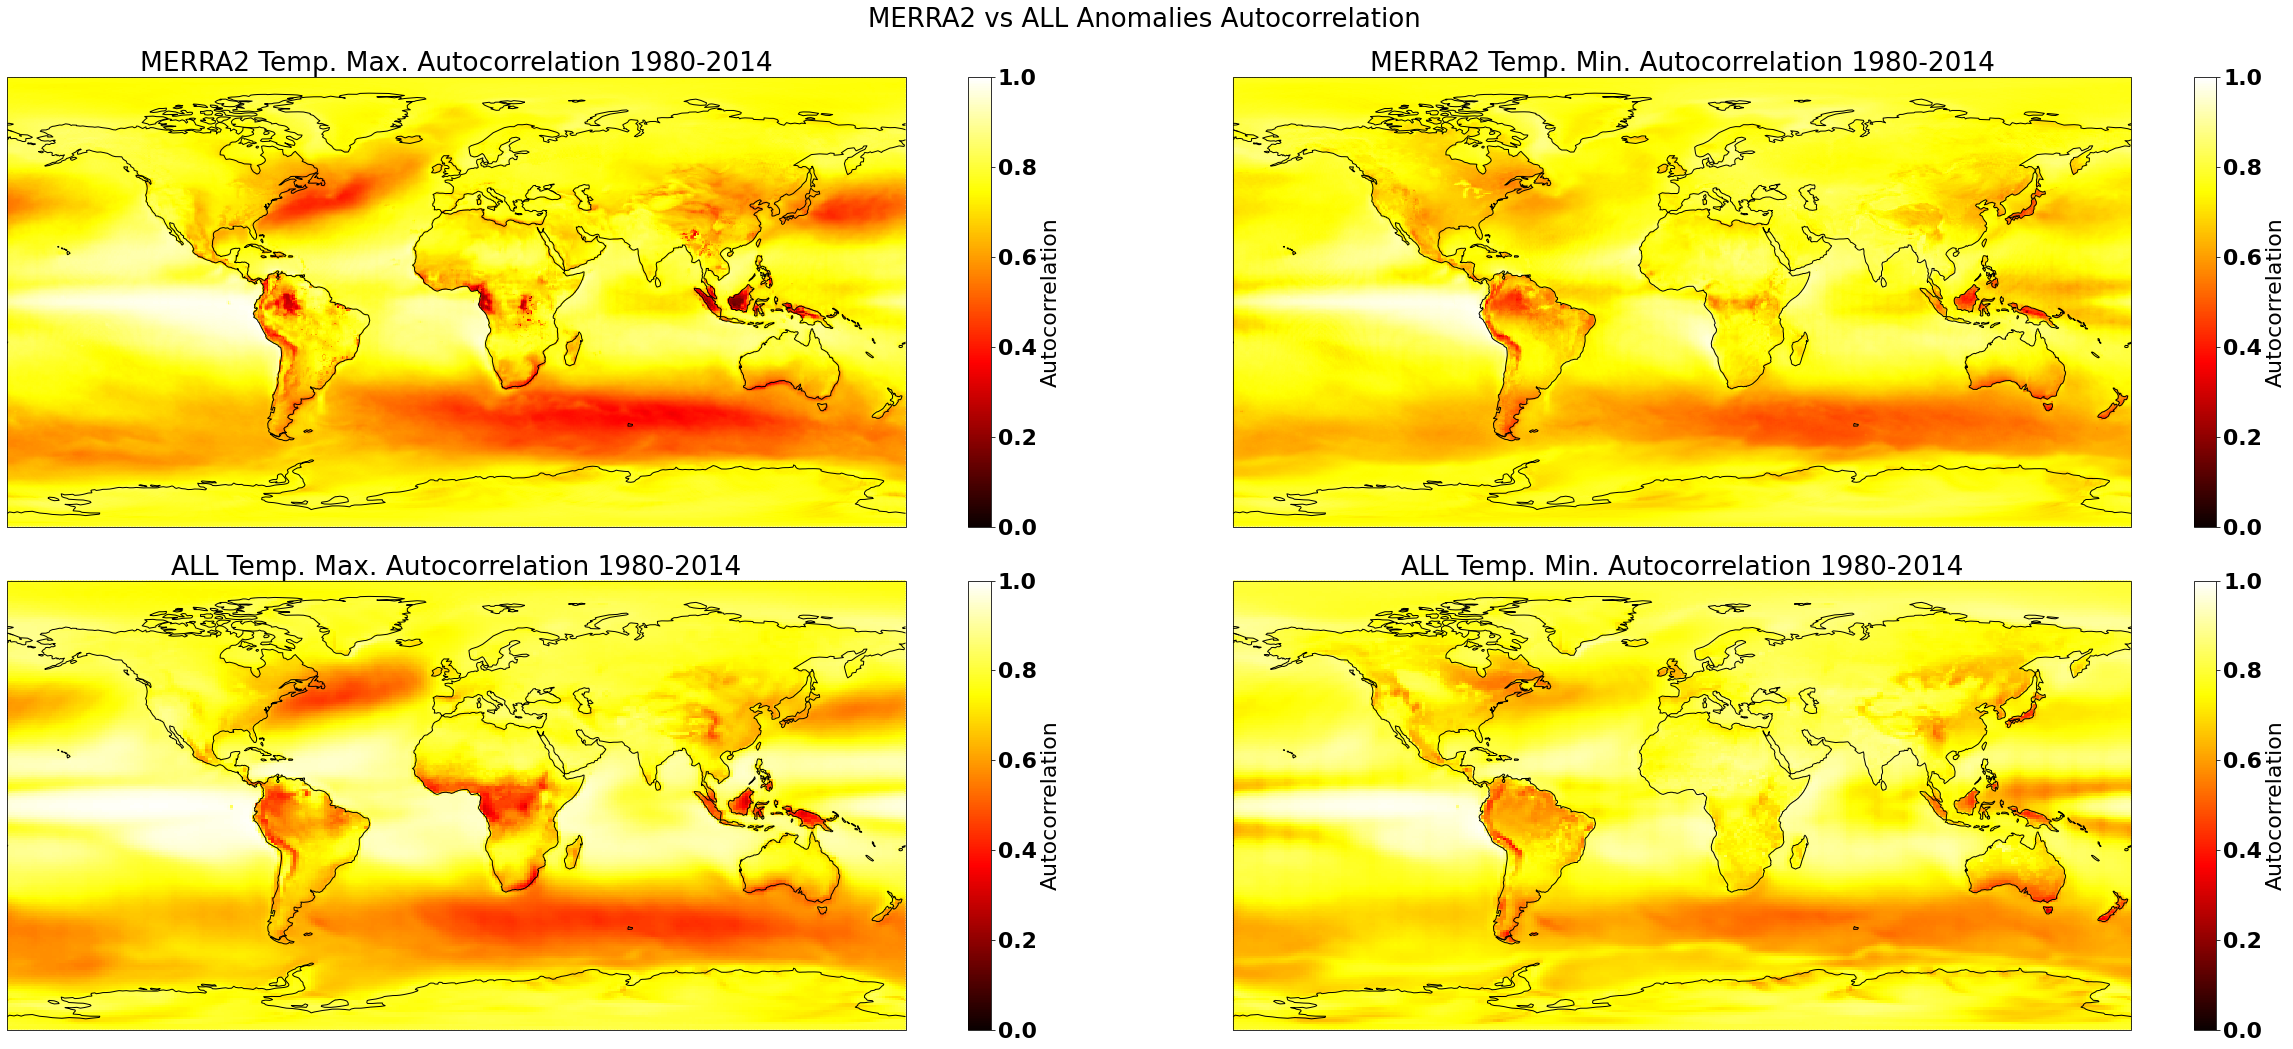

In [24]:
from matplotlib import rc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 15), facecolor='w', subplot_kw=dict(projection=ccrs.PlateCarree()))
f.suptitle(f"MERRA2 vs ALL Anomalies Autocorrelation", fontsize=26)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

cmap="hot"
vmax=1
vmin=0

merra2_max_auto_anomalies.plot(ax=ax1, cmap=cmap, vmax=vmax, vmin=vmin)
ax1.set_title("MERRA2 Temp. Max. Autocorrelation 1980-2014")
ax1.coastlines()
merra2_min_auto_anomalies.plot(ax=ax2, cmap=cmap, vmax=vmax, vmin=vmin)
ax2.set_title("MERRA2 Temp. Min. Autocorrelation 1980-2014")
ax2.coastlines()
all_max_auto_anomalies.plot(ax=ax3, cmap=cmap, vmax=vmax, vmin=vmin)
ax3.set_title("ALL Temp. Max. Autocorrelation 1980-2014")
ax3.coastlines()
all_min_auto_anomalies.plot(ax=ax4, cmap=cmap, vmax=vmax, vmin=vmin)
ax4.set_title("ALL Temp. Min. Autocorrelation 1980-2014")
ax4.coastlines()

f.tight_layout()
f.savefig("out.png")

Overwrite existing file: bilinear_361x576_192x288.nc 
 You can set reuse_weights=True to save computing time.


/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/xesmf/frontend.py:412: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


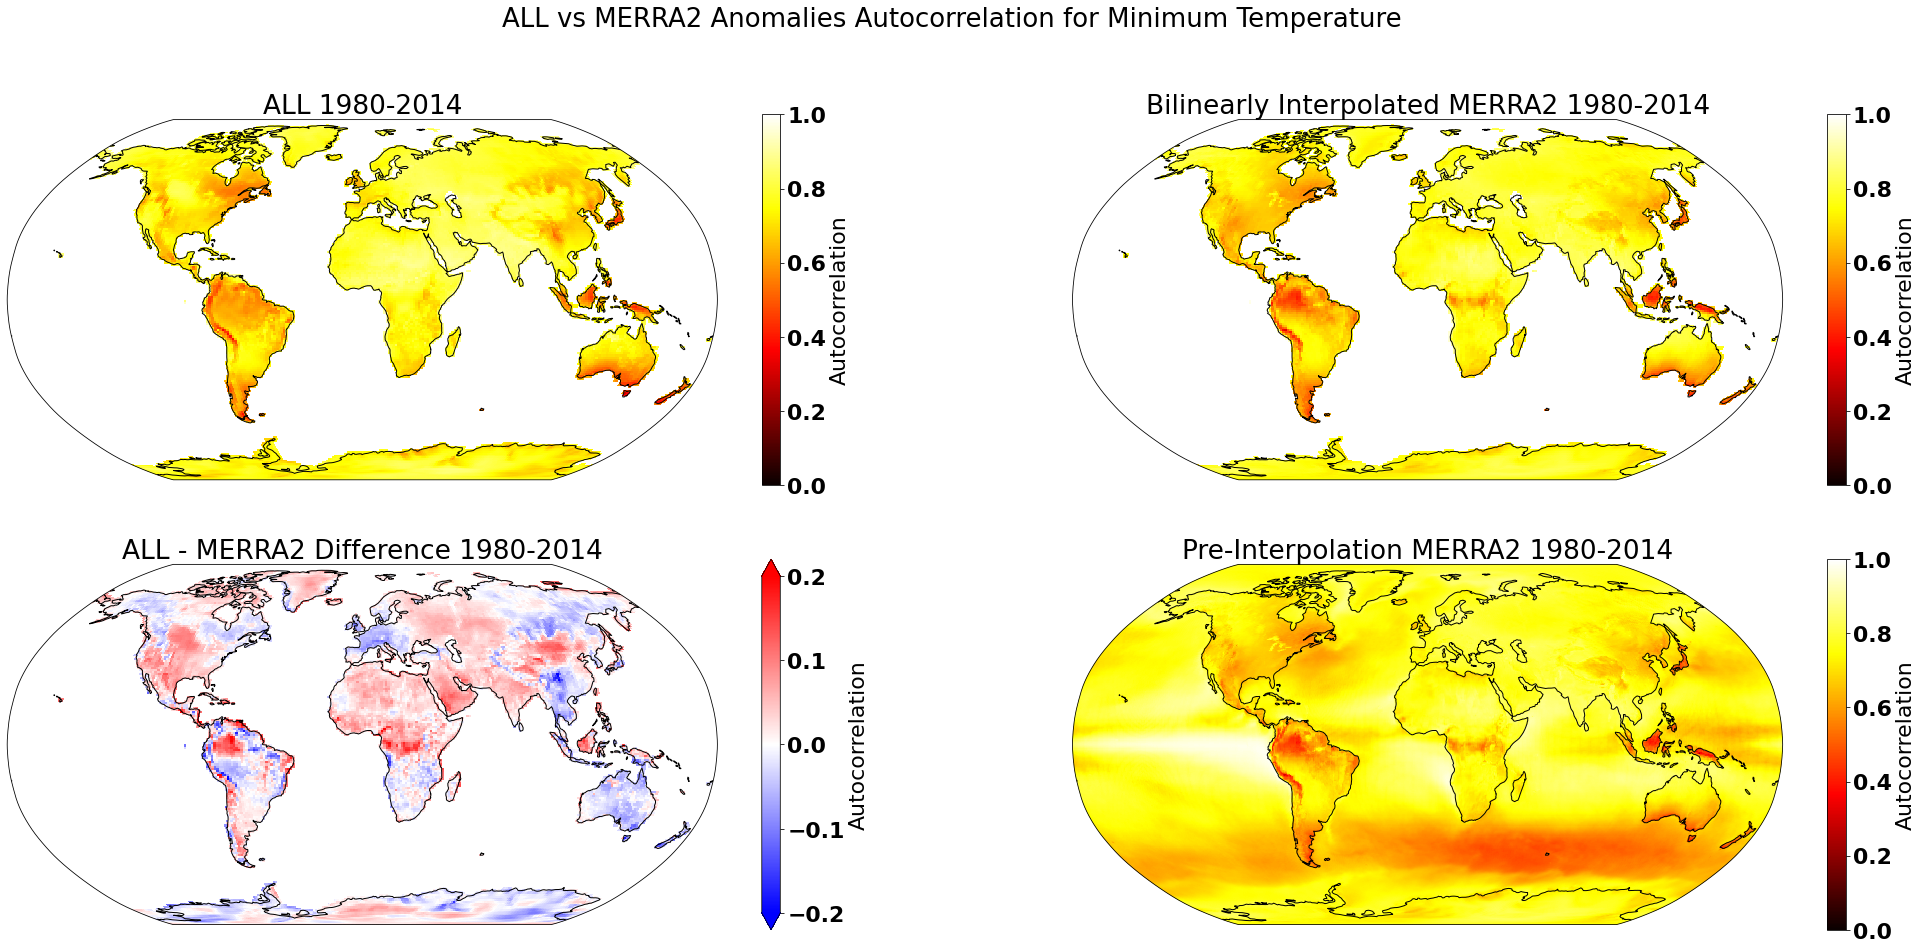

In [17]:
from matplotlib import rc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray
from analysis import bilinear_interpolation as bi_interp
from paths import land_mask

auto_all_min = xarray.open_dataset("../data/autocorrelation/auto_all_min.nc")["Autocorrelation"]
auto_merra_min = xarray.open_dataset("../data/autocorrelation/auto_merra_min.nc")["Autocorrelation"]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(35, 15), facecolor='w', subplot_kw=dict(projection=ccrs.Robinson()))
f.suptitle(f"ALL vs MERRA2 Anomalies Autocorrelation for Minimum Temperature", fontsize=26)
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})

cmap="hot"
vmax=1
vmin=0
auto_merra_interp = bi_interp(auto_merra_min, auto_all_min)

# land mask
land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"]
auto_all_min = auto_all_min.where(land_m>0)
auto_merra_interp = auto_merra_interp.where(land_m>0)

auto_all_min.plot(ax=ax1, vmax=vmax, vmin=vmin, cmap=cmap, transform=ccrs.PlateCarree())
auto_merra_interp.plot(ax=ax2, vmax=vmax, vmin=vmin, cmap=cmap, transform=ccrs.PlateCarree())
(auto_all_min - auto_merra_interp).plot(ax=ax3, cmap="bwr", transform=ccrs.PlateCarree(), vmax=0.2, vmin=-0.2)
auto_merra_min.plot(ax=ax4, vmax=vmax, vmin=vmin, cmap=cmap, transform=ccrs.PlateCarree())

ax1.set_title("ALL 1980-2014")
ax2.set_title("Bilinearly Interpolated MERRA2 1980-2014")
ax3.set_title("ALL - MERRA2 Difference 1980-2014")
ax4.set_title("Pre-Interpolation MERRA2 1980-2014")

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()